In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import pandas as pd

feature_names =  ['accX', 'accY', 'accZ', 'gyroX', 'gyroY', 'gyroZ', 'magX', 'magY', 'magZ']

cat_dict = {'1a': 0,'1b': 1,'2a': 2, '2b': 3, '2c': 4, '2d': 5, '3a': 6, '3b': 7, 'TRANSITION': -1}

def process_file(filename):
    col_names = ['timestamp'] + feature_names + ['cat']
    df = pd.read_csv(filename, header=None, names=col_names)
    df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)
    df = df.dropna()
    df['cat'] = df['cat'].map(cat_dict) 
    
    df['upright'] = (df['cat'] ==  1) | (df['cat'] == 0) |  (df['cat'] == 7) | (df['cat'] == 6)
    df['smartphone'] = (df['cat'] == 1) | (df['cat'] == 3) | (df['cat'] == 5) | (df['cat'] == 7)
    
    df.upright = df.upright.astype(int)
    df.smartphone = df.smartphone.astype(int)
    
    return df

df1_unfiltered = process_file('1_50Hz.csv')
df2_unfiltered = process_file('2_50Hz.csv')
df3_unfiltered = process_file('3_50Hz.csv')
df4_unfiltered = process_file('4_50Hz.csv')

df1234 = pd.concat([df1_unfiltered,df2_unfiltered,df3_unfiltered,df4_unfiltered])

def normalize(df):
    for feature in feature_names:
        df[feature] = (df[feature] - df1234[feature].mean()) / (df1234[feature].max() - df1234[feature].min())
        
normalize(df1_unfiltered)
normalize(df2_unfiltered)
normalize(df3_unfiltered)
normalize(df4_unfiltered)

df1 = df1_unfiltered[df1_unfiltered['cat'] != -1]
df2 = df2_unfiltered[df2_unfiltered['cat'] != -1]
df3 = df3_unfiltered[df3_unfiltered['cat'] != -1]
df4 = df4_unfiltered[df4_unfiltered['cat'] != -1]

df12 = pd.concat([df1, df2])
df123 = pd.concat([df1, df2, df3])

print(df1_unfiltered.shape, df2_unfiltered.shape, df3_unfiltered.shape, df4_unfiltered.shape)
print(df1.shape, df2.shape, df3.shape, df4.shape)

(773711, 13) (846331, 13) (888477, 13) (247099, 13)
(673516, 13) (747021, 13) (678459, 13) (147537, 13)


In [2]:
# TensorFlow and tf.keras
import tensorflow as tf

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

import warnings
warnings.filterwarnings('ignore')

1.14.0


In [3]:
from collections import Counter
from keras.utils import to_categorical

def window_stack(a):
    n = a.shape[0]
    result = np.zeros((128 + 64 * (n//64), 9))
    result[:a.shape[0], :a.shape[1]] = a
#     print(result.shape)
#     print(result[1*64 : 128+1*64].shape)
    result =  np.dstack( result[i*64 : 128+i*64] for i in range(n // 64) )
    result = np.transpose(result, (2, 0, 1))
    return result

def construct_y(a):
    n = a.shape[0]
    result = np.zeros((n//64))
#     print(result.shape)
    for i in range(n //64):
        subarr = a.values[i*64 : 128+i*64]
        result[i] = Counter(subarr).most_common(1)[0][0]
    return result

def prepare_for_training(training_set, testing_set, category):
    
    #training data
    trainX, trainy = training_set[feature_names], training_set[category]
    # load all test
    testX, testy = testing_set[feature_names], testing_set[category]

    testy = construct_y(testy)
    trainy = construct_y(trainy)
    
    trainX = window_stack(trainX.values)
    testX = window_stack(testX.values)
        
    # one hot encode y
    trainy = to_categorical(trainy)
    testy = to_categorical(testy)
    print(trainX.shape, trainy.shape, testX.shape, testy.shape)
    return trainX, trainy, testX, testy

Using TensorFlow backend.


In [4]:
from tensorflow.python.keras import *
from tensorflow.python.keras.layers import *

from numpy import mean
from numpy import std

# fit and evaluate a model
def evaluate_model(trainX, trainy, testX, testy, models):
    verbose, epochs, batch_size = 0, 25, 64
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    # reshape data into time steps of sub-sequences
    n_steps, n_length = 4, 32
    trainX = trainX.reshape((trainX.shape[0], n_steps, n_length, n_features))
    testX = testX.reshape((testX.shape[0], n_steps, n_length, n_features))
    # define model
    model = Sequential()
    model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None,n_length,n_features)))
    model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))
    model.add(TimeDistributed(Dropout(0.5)))
    model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(100))
    model.add(Dropout(0.5))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)
    models.append(model)
    # evaluate model
    _, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
    return accuracy
 
# summarize scores
def summarize_results(scores):
    print(scores)
    # summarize mean and standard deviation
    m, s = mean(scores), std(scores)
    print('%.3f%% (+/-%.3f)' % (m, s))

# m, s = mean(scores), std(scores)
# print('Accuracy: %.3f%% (+/-%.3f)' % (m, s))

In [9]:
def train_models_for_datasets(trainX, trainy, testX, testy):
    models = []
    # repeat experiment
    scores = list()
    for r in range(1):
        score = evaluate_model(trainX, trainy, testX, testy, models)
        score = score * 100.0
        print('#%d: %.3f' % (r+1, score))
        scores.append(score)
    # summarize results
    summarize_results(scores)
    return models, scores

In [10]:
from matplotlib import pyplot

# plot a histogram of each variable in the dataset
def plot_variable_distributions(trainX):
	# remove overlap
	cut = int(trainX.shape[1] / 2)
	longX = trainX[:, -cut:, :]
	# flatten windows
	longX = longX.reshape((longX.shape[0] * longX.shape[1], longX.shape[2]))
	print(longX.shape)
	pyplot.figure()
	xaxis = None
	for i in range(longX.shape[1]):
		ax = pyplot.subplot(longX.shape[1], 1, i+1, sharex=xaxis)
		ax.set_xlim(-1, 1)
		if i == 0:
			xaxis = ax
		pyplot.hist(longX[:, i], bins=100)
	pyplot.show()

In [11]:
def dataset_to_activities(df):
    activities = []
    current_activ = 0
    counter = 0
    for _, row in df.iterrows():
        if row['cat'] == current_activ:
            counter += 1
        else:
            activities.append((current_activ, counter))
            current_activ = row['cat']
            counter = 0
    return activities

divided = dataset_to_activities(df3_unfiltered)
print(divided)

[(0, 0), (-1, 4799), (1, 16415), (-1, 1520), (6, 7871), (-1, 3165), (5, 43571), (-1, 3500), (2, 16117), (-1, 2978), (3, 15018), (-1, 2168), (6, 15270), (-1, 1940), (0, 5022), (-1, 2058), (6, 35522), (-1, 34690), (0, 1678), (-1, 2708), (3, 1716), (-1, 2547), (7, 4570), (-1, 2688), (0, 1121), (-1, 1223), (6, 1124), (-1, 1325), (0, 1763), (-1, 1564), (7, 3172), (-1, 5111), (4, 12067), (-1, 2358), (2, 3070), (-1, 3192), (0, 20668), (-1, 1178), (0, 1915), (-1, 5618), (4, 21016), (-1, 2339), (3, 1917), (-1, 1159), (2, 2172), (-1, 1748), (7, 2012), (-1, 1476), (6, 2409), (-1, 1838), (0, 4469), (-1, 1028), (1, 18012), (-1, 2091), (7, 4179), (-1, 2162), (6, 5169), (-1, 1246), (7, 1043), (-1, 1201), (7, 406), (-1, 18805), (0, 9618), (-1, 2358), (5, 7117), (-1, 3210), (7, 10422), (-1, 1518), (0, 3645), (-1, 2123), (5, 6311), (-1, 5761), (4, 32620), (-1, 2379), (1, 15016), (-1, 8283), (1, 23666), (-1, 3526), (7, 6273), (-1, 6375), (5, 4464), (-1, 1195), (5, 1010), (-1, 4047), (4, 17959), (-1, 2949

In [12]:
results = {}

for category in ['cat', 
#                  'upright', 'smartphone'
                ]:
    print(category)
    trainX, trainy, testX, testy = prepare_for_training(df12, df3, category)
    models, scores = train_models_for_datasets(trainX, trainy, testX, testy)
    results[category] = (models, scores)

cat
(22195, 128, 9) (22195, 8) (10600, 128, 9) (10600, 8)
#1: 54.538
[54.53773736953735]
54.538% (+/-0.000)


In [13]:
print(results)

def get_predictions(cat):
    n_steps, n_length = 4, 32
    n_features = trainX.shape[2]
    
    test = testX.reshape((testX.shape[0], n_steps, n_length, n_features))
    
    return [np.argmax(x) for x in results[cat][0][results[cat][1].index(
        max(results[cat][1]))].predict(test, batch_size=32)]

# smartphone = get_predictions('smartphone')
# upright = get_predictions('upright')
categories = get_predictions('cat')

{'cat': ([<tensorflow.python.keras.engine.sequential.Sequential object at 0x000002D04BF76160>], [54.53773736953735])}


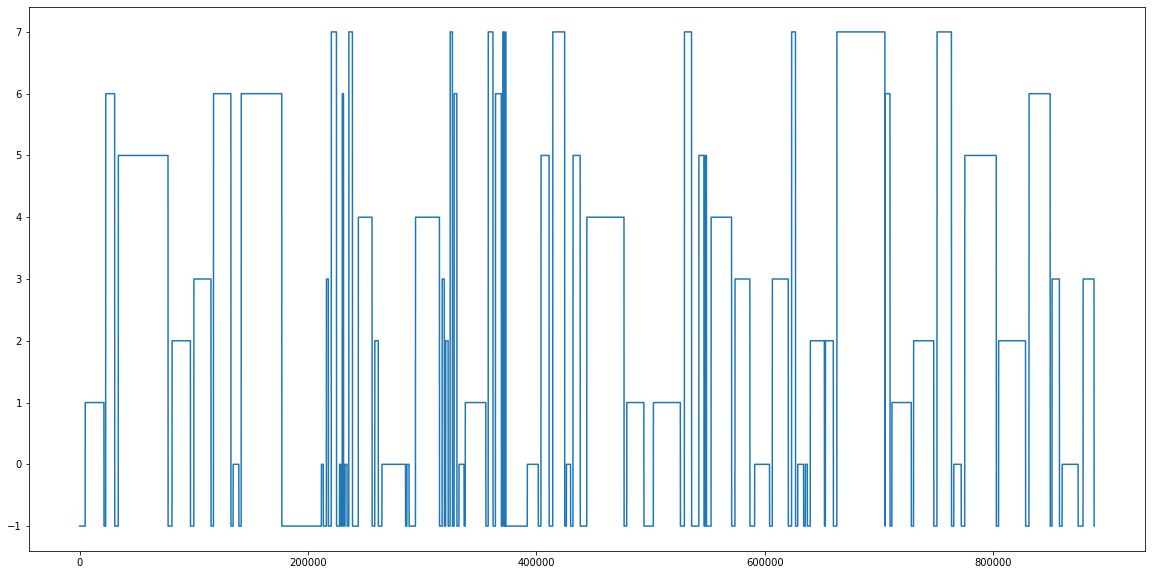

In [14]:
plt.figure(figsize=(20, 10))
plt.plot([x for x in range(888477)], df3_unfiltered.cat)

In [15]:
import operator


def restore(predictions, original, neutral_element=0):
    restored = []

    zeros_count = 0
    for i in range(0, 888477):
        if original[i] == neutral_element:
            restored.append(neutral_element)
            zeros_count += 1
        else:
            restored.append((predictions[max(0, (i - zeros_count)//64 - 1)], 
                               predictions[min(10600-1, (i - zeros_count)//64)]))
          
    histograms = []  
    histogram = {}
    current_category = -2

    for i in range(0,  888447):
      if restored[i] == neutral_element:
        current_category = -2
      else:
        if current_category == -2:
          j = i
          histogram = {}
          while restored[j] != neutral_element:
            if restored[j][0] in histogram:
              histogram[restored[j][0]] += 1
            else:
              histogram[restored[j][0]] = 1
            if restored[j][1] in histogram:
              histogram[restored[j][1]] += 1
            else:
             histogram[restored[j][1]] = 1
            j += 1
          current_category = max(histogram.items(), key=operator.itemgetter(1))[0]
          histograms.append(histogram)
    
        restored[i] = current_category

    print(len(restored))
    print(len(original))
    return restored, histograms

888477
888477
0.28930855835322694
[{1: 31552, 0: 256, 3: 256, 7: 640, 6: 128}, {6: 15712, 4: 32}, {6: 32, 4: 86624, 1: 384, 0: 104}, {0: 32236}, {0: 22305, 1: 7680, 6: 53}, {0: 643, 6: 29771, 3: 128}, {0: 9662, 1: 384}, {0: 1672, 6: 69374}, {6: 2, 0: 1218, 1: 2138}, {1: 3432, 5: 2}, {1: 446, 5: 2046, 3: 6365, 7: 256, 0: 29}, {3: 35, 0: 2209}, {0: 102, 6: 2148}, {6: 28, 0: 3492, 7: 8}, {0: 56, 7: 3941, 3: 2048, 1: 256, 4: 45}, {7: 19, 4: 23379, 1: 128, 3: 512, 0: 98}, {0: 6142}, {0: 22688, 1: 18394, 4: 256}, {1: 2982, 0: 768, 4: 82}, {4: 42000, 1: 34}, {4: 30, 1: 3774, 0: 32}, {1: 32, 0: 4285, 7: 29}, {0: 35, 7: 3043, 3: 890, 6: 58}, {3: 6, 6: 4778, 0: 36}, {6: 28, 0: 8886, 1: 26}, {0: 166, 1: 34269, 7: 1335, 5: 256}, {1: 9, 7: 8137, 3: 128, 6: 86}, {6: 9895, 0: 384, 7: 61}, {6: 3, 7: 2085}, {7: 774, 0: 40}, {7: 24, 0: 7000, 1: 12155, 4: 59}, {1: 5, 4: 14222, 3: 9}, {4: 55, 3: 1783, 7: 17536, 1: 1088, 5: 384}, {1: 7230, 4: 62}, {1: 2, 4: 12622}, {4: 65223, 1: 19}, {4: 45, 1: 25765, 7: 2

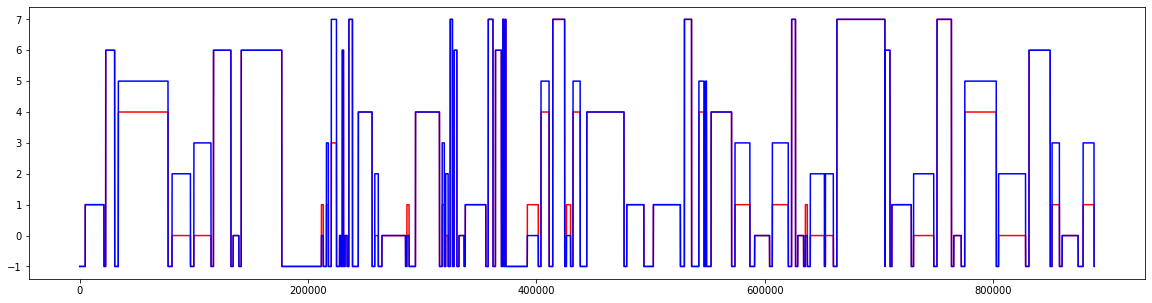

In [16]:
def compare_results(original, to_restore, neutral_element=0):
    restored, histograms = restore(to_restore, original.values, neutral_element)
    error = np.mean( restored != original.values )
    print(error)
    print(histograms)
    plt.figure(figsize=(20, 5))
    plt.plot([x for x in range(len(restored))], restored, c='r')
    plt.plot([x for x in range(len(original))], original, c='b')
    
# compare_results(df3_unfiltered['smartphone'], smartphone)
# compare_results(df3_unfiltered['upright'], upright)
compare_results(df3_unfiltered['cat'], categories, -1)

,timestamp,cat
0,2019-07-10_141406:660,-1.0
1,2019-07-10_141406:680,-1.0
2,2019-07-10_141406:700,-1.0
3,2019-07-10_141406:720,-1.0
4,2019-07-10_141406:740,-1.0
5,2019-07-10_141406:760,-1.0
6,2019-07-10_141406:780,-1.0
7,2019-07-10_141406:800,-1.0
8,2019-07-10_141406:820,-1.0
9,2019-07-10_141406:840,-1.0
